***Please use Colab to open this file***


For this project We mainly focus on EWC and Gradient Episodic Memory (GEM) learning strategy. For EWC portion, please check out this link - **https://www.kaggle.com/ruinanzhang44/project-2-rotated-mnist?scriptVersionId=31496756**

# Goal

Catastrophic Forgetting make the model no longer suitable for MNIST problem. In the following section we will discuss how to reduce catastrofic forgetting with Gradient Episodic Memory (GEM). 

Besides accuracy, there are two additional metrics used to assess the ability of the algorithm to transfer knowledge - Backward transfer (BWT) and Forward transfer (FWT)

*   BWT: the influence that learning a task t has on the performance on a previous task k ≺ t
*   FWT: the influence that learning a task t has on the performance on a future task k ≻ t

# Dataset

**Training Dataset**: 60000 * 28 * 28

**Test Dataset**: 10000 * 28 * 28

**Rotation**: Randomized rotation between 0~180 degree

**Tasks number**: 20


# Gradient Episodic Memory

When performing current task, GEM allows to access Episodic Memory (Mt) where the subsets data of previous tasks being stored. We use integer task descriptors and focus on minimizing negative backward transfer (catastrophic forgetting) by the efficient use of episodic memory Mt.

class Net(nn.Module) definition:

**initialization**:
Use MLP as the base neural network. 
Allocate following parameters: 

1.   episodic memory: memory_data, memory labs
2.   temporary synaptic memory: gradient dimensions and gradients
3.   counters: observed tasks sequence, old_task, memory counter, nc_per_task
4.   other parameters: layers, hidden layers, margin (memory strength), outputs, cross entropy loss, optimizer

**forward**:

return self.net(x)

**observe**:

params: 
*   x -> input
*   t -> index task descriptor
*   y -> output

```python
    def observe(self, x, t, y):
        # 1. update memory
        # Mt ←{} for all t=1,...,T.
        # assign old task to t
        if t != self.old_task:
            self.observed_tasks.append(t)
            self.old_task = t

        # 2. Update ring buffer storing examples from current task
        # R ← 0 ∈ R^T*T
        bsz = y.data.size(0)
        endcnt = min(self.mem_cnt + bsz, self.n_memories)
        effbsz = endcnt - self.mem_cnt
        self.memory_data[t, self.mem_cnt: endcnt].copy_(
            x.data[: effbsz])
        if bsz == 1:
            self.memory_labs[t, self.mem_cnt] = y.data[0]
        else:
            self.memory_labs[t, self.mem_cnt: endcnt].copy_(
                y.data[: effbsz])
        self.mem_cnt += effbsz
        if self.mem_cnt == self.n_memories:
            self.mem_cnt = 0

        # 3. compute gradient on previous tasks
        # gk ← ∇θ l(fθ, Mk)
        if len(self.observed_tasks) > 1:
            for tt in range(len(self.observed_tasks) - 1):
                self.zero_grad()
                # fwd/bwd on the examples in the memory
                past_task = self.observed_tasks[tt]

                offset1, offset2 = 0, self.nc_per_task
                # g←∇θl(fθ(x,t),y)
                ptloss = self.ce(self.forward(self.memory_data[past_task],
                        past_task)[:, offset1: offset2],
                        self.memory_labs[past_task] - offset1)
                # gk ← ∇θ l(fθ, Mk) for all k < t
                ptloss.backward()
                store_grad(self.parameters, self.grads, self.grad_dims,
                           past_task)

        # 4. compute the grad on the current minibatch
        # g←∇θl(fθ(x,t),y)
        self.zero_grad()

        offset1, offset2 = 0, self.nc_per_task
        loss = self.ce(self.forward(x, t)[:, offset1: offset2], y - offset1)
        loss.backward()

        # 5. check if gradient violates constraints
        if len(self.observed_tasks) > 1:
            # 5.1 copy gradient
            store_grad(self.parameters, self.grads, self.grad_dims, t)
            indx = torch.LongTensor(self.observed_tasks[:-1])
            dotp = torch.mm(self.grads[:, t].unsqueeze(0),
                            self.grads.index_select(1, indx))
            if (dotp < 0).sum() != 0:
                # 5.2 g ← PROJECT(g, g1, . . . , gt−1)
                project2cone2(self.grads[:, t].unsqueeze(1),
                              self.grads.index_select(1, indx), self.margin)
                # 5.3 copy gradients back θ ← θ − αg.
                overwrite_grad(self.parameters, self.grads[:, t],
                               self.grad_dims)
        self.opt.step()

```


Other Helper method for Observe:

project2cone2: Project the proposed gradient g to the closest gradient g ̃ (in squared l2 norm) satisfying all the constraints using Quadratic Program (QP) with inequality constraints, minimizez 1/2* z⊤Cz + p⊤z

```python
def project2cone2(gradient, memories, margin=0.5, eps=1e-3):
  @param gradient
  @param memories
  @param margin
  @param eps
    memories_np = memories.cpu().t().double().numpy()
    gradient_np = gradient.cpu().contiguous().view(-1).double().numpy()
    t = memories_np.shape[0]
    P = np.dot(memories_np, memories_np.transpose())
    P = 0.5 * (P + P.transpose()) + np.eye(t) * eps
    q = np.dot(memories_np, gradient_np) * -1
    G = np.eye(t)
    h = np.zeros(t) + margin
    v = quadprog.solve_qp(P, q, G, h)[0]
    x = np.dot(v, memories_np) + gradient_np
    gradient.copy_(torch.Tensor(x).view(-1, 1))
```
store_grad: store parameter gradients of previous tasks (grad_dims)
```python
def store_grad(pp, grads, grad_dims, tid):
  @param pp previous parameters
  @param grads gradients
  @param grad_dims
  @param tid task ID
    # store the gradients
    grads[:, tid].fill_(0.0)
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            grads[beg: en, tid].copy_(param.grad.data.view(-1))
        cnt += 1
```
overwrite_grad: Write new gradient into grad_dims

```python
def overwrite_grad(pp, newgrad, grad_dims):
  @param pp previous parameters
  @param newgrad new gradient
  @param grad_dims
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            this_grad = newgrad[beg: en].contiguous().view(
                param.grad.data.size())
            param.grad.data.copy_(this_grad)
        cnt += 1
```


**Evaluate**
```python
def eval_tasks(model, tasks, args):
    # 1. r←0∈RT
    # 2. for (x, y) in Continuum(k) do
    for i, task in enumerate(tasks):
        # 3. rk ← 0
        # 4. for (x, y) in Continuum(k) do
        for b_from in range(0, x.size(0), eval_bs):
            
            #b_to = min(b_from + eval_bs, x.size(0) - 1)
            if b_from == b_to:
                xb = x[b_from].view(1, -1)
                yb = torch.LongTensor([y[b_to]]).view(1, -1)
            else:
                xb = x[b_from:b_to]
                yb = y[b_from:b_to]
            # 5. rk ← rk+accuracy(fθ(x,k),y), )
            rt += (pb == yb).float().sum()

        # 5. rk ← rk / len(Continuum(k))
        result.append(rt / x.size(0))

    return result
```



# Result:

Highest Final accuracy: 0.9021

Backward Transfer: 0.0499

Forward Transfer:  0.6483


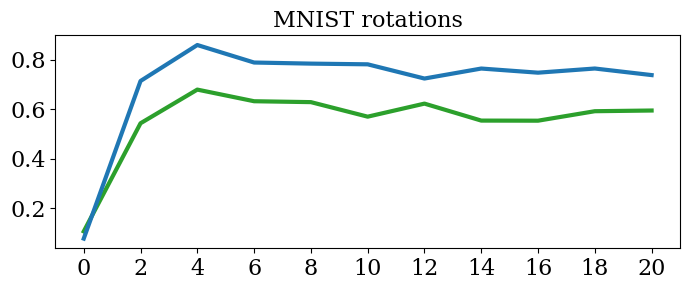

In [0]:
from IPython.display import Image
Image(filename='results/evoplot_0.9.png') 

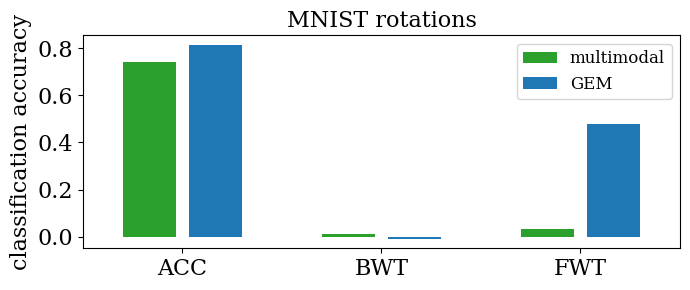

In [0]:
Image(filename='results/barplot_0.9.png') 

In [0]:
text_file = open("results/gem_mnist_rotations.pt_01_34.txt")
file_content = text_file.read()
print(file_content)
text_file.close()

0.1244 0.1211 0.1175 0.1008 0.0813 0.0761 0.0738 0.0820 0.0818 0.0849 0.0846 0.0751 0.0985 0.1103 0.1426 0.1242 0.1237 0.1192 0.1076 0.1050
|
0.7663 0.7349 0.6552 0.5127 0.4063 0.2741 0.2665 0.1776 0.1371 0.1315 0.1323 0.1363 0.1364 0.1527 0.1591 0.1502 0.1609 0.1652 0.1762 0.1923
0.8429 0.8582 0.8023 0.6628 0.5231 0.3567 0.3524 0.2548 0.1961 0.1663 0.1659 0.1376 0.1289 0.1285 0.1351 0.1312 0.1378 0.1410 0.1443 0.1508
0.8112 0.8645 0.8572 0.7864 0.6773 0.4880 0.4805 0.3264 0.2076 0.1621 0.1636 0.1383 0.1297 0.1302 0.1335 0.1330 0.1379 0.1453 0.1421 0.1539
0.8047 0.8731 0.8930 0.8770 0.8225 0.6669 0.6594 0.4708 0.3127 0.2194 0.2198 0.1631 0.1395 0.1374 0.1415 0.1406 0.1596 0.1678 0.1783 0.1919
0.7728 0.8469 0.8708 0.8893 0.8779 0.7950 0.7882 0.6237 0.4347 0.2965 0.2950 0.2181 0.1959 0.1873 0.1805 0.1673 0.1706 0.1672 0.1564 0.1572
0.8217 0.8792 0.8964 0.9105 0.9054 0.8806 0.8773 0.7832 0.5942 0.4033 0.4002 0.2286 0.1745 0.1690 0.1583 0.1472 0.1582 0.1676 0.1718 0.1829
0.8520 0.8966 0.90

Parameters:

*   number of hidden neurons at each layer (n_hiddens): 100
*   number of hidden layers (n_layers): 6
*   n_memories (number of memories per task): 512
*   memory dependency: 1.0
*   number of epochs per task (n_epochs): 1
*   batch_size: 10
*   learning rate (lr): 0.1


# Run the project

Download [GradientEpisodicMemory.zip](https://drive.google.com/open?id=1QSi3ua8e41kUDu364s4e_hs5lBJUNN31) and unzip it and upload to your google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
ERROR! Session/line number was not unique in database. History logging moved to new session 64


go to the folder where you put your unzipped GradientEpisodicMemory

cd **YOURPATH/**GradientEpisodicMemory

In [0]:
cd content/drive/My Drive/Spring2020/AI/hw2/MNIST/GradientEpisodicMemory

/content/drive/My Drive/Spring2020/AI/hw2/MNIST/GradientEpisodicMemory


In [0]:
!pip install quadprog
!chmod +x run_experiments.sh

In [0]:
!./run_experiments.sh

results/gem_mnist_rotations.pt_01_34
acc:  tensor(0.9021)
bwt:  tensor(0.0499)
fwt:  tensor(0.6483)


Paper referenced:


[Gradient Episodic Memory for Continual Learning](https://arxiv.org/pdf/1706.08840.pdf)



